In [1]:
import pandas as pd
import numpy as np
import pathlib as pl

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

from scipy.stats import mannwhitneyu, fisher_exact, pearsonr, kruskal

In [5]:
import sys
sys.path.append("../../FinalCode/")
import download.download as dwnl
import utils.plotting as plting
#import adVMP.adVMP_discovery as discov
#import adVMP.adVMP_plots as advmpplt
#import adVMP.adVMP_crossval as advmpcross

In [2]:
# For figures
colors = sns.color_palette("muted")
palette = {"Normal": colors[0], "NADJ-A": colors[3], "NADJ-C": colors[2], "Adenoma": colors[3], "SSL": colors[4], "Cancer": colors[5]}
fig_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/ArticleFigures/unit")

In [3]:
base_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC/")
base_dir4 = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC4/")

data_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/")

bad_probes = pd.read_csv(data_dir / "auxiliary" / "sketchy_probe_list_epic.csv",index_col=0).values.ravel()
sample_origin_path = pl.Path(data_dir / "clinical" / "sample_origin_wbatch.csv")

clinical_path = pl.Path(data_dir / "clinical" / "cleaned_clinical_reduced_diet.csv")
target_path = pl.Path(data_dir / "clinical" / "targets.csv")

In [6]:
EPIC2_b, EPIC2_clin, EPIC2_samples, EPIC2_phenotypes, EPIC3_b, EPIC3_clin, EPIC3_samples, EPIC3_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir, clinical_path=clinical_path, target_path=target_path,
                  bad_probes=bad_probes, EPIC4=False) 

30it [00:05,  5.15it/s]


In [7]:
EPIC4_b, EPIC4_clin, EPIC4_samples, EPIC4_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir4, clinical_path=clinical_path, target_path=target_path, 
                  bad_probes=bad_probes, EPIC4=True) 

18it [00:03,  4.91it/s]


# Find most variable probes

In [31]:
from scipy.stats import median_abs_deviation
mad2 = median_abs_deviation(EPIC2_b)
mad2 = pd.Series(mad2, index=EPIC2_b.columns)
mad3 = median_abs_deviation(EPIC3_b)
mad3 = pd.Series(mad3, index=EPIC3_b.columns)
mad4 = median_abs_deviation(EPIC4_b)
mad4 = pd.Series(mad4, index=EPIC4_b.columns)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


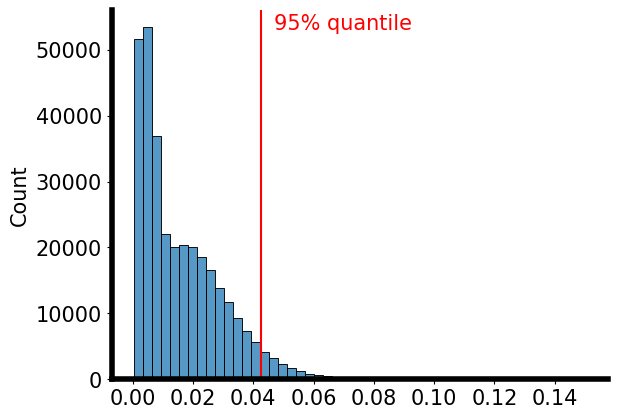

In [32]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=mad2.clip(None,0.15), bins=50, ax=ax)
plt.axvline(mad2.quantile(0.95), c="r")
plt.text(1.1*mad2.quantile(0.95),53000,"95% quantile",c="r", fontdict = {"size": 15})
plting.transform_plot_ax(ax, legend_title="", ftsize=15)
fig.savefig(fig_dir / "SWEPIC1" / "mad_95_qt.svg", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


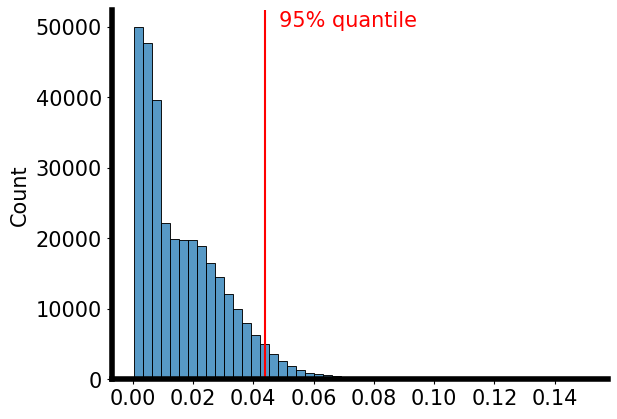

In [33]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=mad3.clip(None,0.15), bins=50, ax=ax)
plt.axvline(mad3.quantile(0.95), c="r")
plt.text(1.1*mad3.quantile(0.95),50000,"95% quantile",c="r", fontdict = {"size": 15})
plting.transform_plot_ax(ax, legend_title="", ftsize=15)
fig.savefig(fig_dir / "SWEPIC2" / "mad_95_qt.svg", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


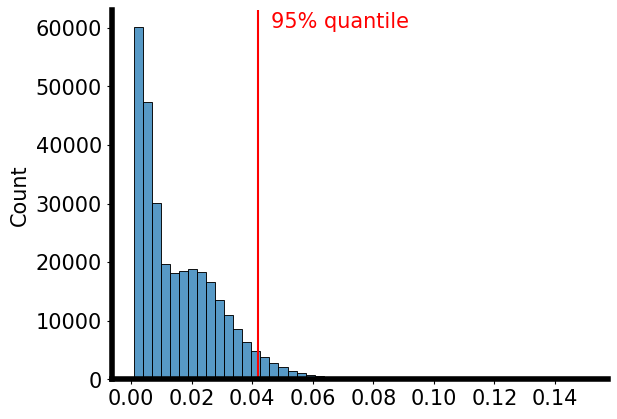

In [34]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=mad4.clip(None,0.15), bins=50, ax=ax)
plt.axvline(mad4.quantile(0.95), c="r")
plt.text(1.1*mad4.quantile(0.95),60000,"95% quantile",c="r", fontdict = {"size": 15})
plting.transform_plot_ax(ax, legend_title="", ftsize=15)
fig.savefig(fig_dir / "SWEPIC3" / "mad_95_qt.svg", bbox_inches="tight")

In [35]:
union_cpgs_5_pct = np.unique(np.concatenate([mad2[mad2>mad2.quantile(0.95)].index,
                mad3[mad3>mad3.quantile(0.95)].index,
                mad4[mad4>mad4.quantile(0.95)].index]))
pd.Series(union_cpgs_5_pct).to_csv("../../FinalData/variable_probes/union_cpgs_5_pct_most_variable.csv")

# Find most variable probes in healthy tissue

In [36]:
from scipy.stats import median_abs_deviation
mad2 = median_abs_deviation(EPIC2_b.loc[EPIC2_phenotypes==0])
mad2 = pd.Series(mad2, index=EPIC2_b.columns)
mad3 = median_abs_deviation(EPIC3_b.loc[EPIC3_phenotypes==0])
mad3 = pd.Series(mad3, index=EPIC3_b.columns)
mad4 = median_abs_deviation(EPIC4_b.loc[EPIC4_phenotypes==0])
mad4 = pd.Series(mad4, index=EPIC4_b.columns)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


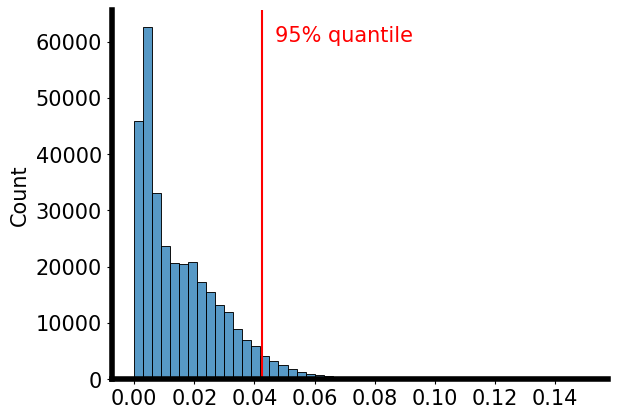

In [43]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=mad2.clip(None,0.15), bins=50, ax=ax)
plt.axvline(mad2.quantile(0.95), c="r")
plt.text(1.1*mad2.quantile(0.95),60000,"95% quantile",c="r", fontdict = {"size": 15})
plting.transform_plot_ax(ax, legend_title="", ftsize=15)
fig.savefig(fig_dir / "SWEPIC1" / "mad_95_qt_onlyhealthy.svg", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


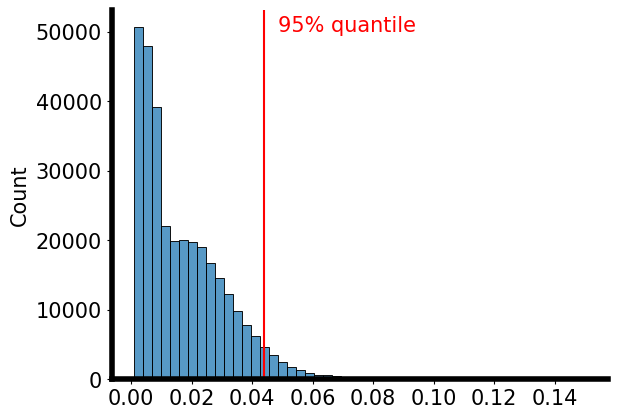

In [38]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=mad3.clip(None,0.15), bins=50, ax=ax)
plt.axvline(mad3.quantile(0.95), c="r")
plt.text(1.1*mad3.quantile(0.95),50000,"95% quantile",c="r", fontdict = {"size": 15})
plting.transform_plot_ax(ax, legend_title="", ftsize=15)
fig.savefig(fig_dir / "SWEPIC2" / "mad_95_qt_onlyhealthy.svg", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


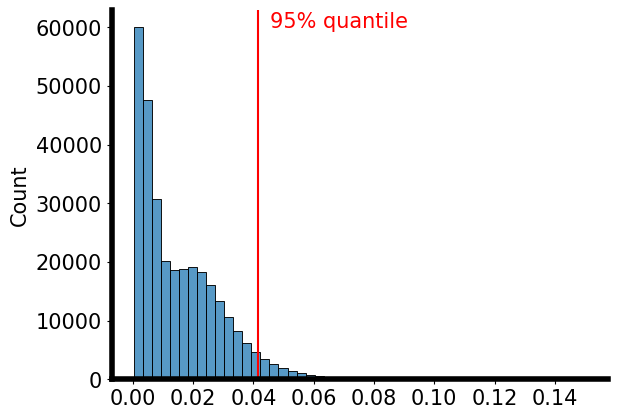

In [39]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=mad4.clip(None,0.15), bins=50, ax=ax)
plt.axvline(mad4.quantile(0.95), c="r")
plt.text(1.1*mad4.quantile(0.95),60000,"95% quantile",c="r", fontdict = {"size": 15})
plting.transform_plot_ax(ax, legend_title="", ftsize=15)
fig.savefig(fig_dir / "SWEPIC3" / "mad_95_qt_onlyhealthy.svg", bbox_inches="tight")

In [40]:
union_cpgs_5_pct = np.unique(np.concatenate([mad2[mad2>mad2.quantile(0.95)].index,
                mad3[mad3>mad3.quantile(0.95)].index,
                mad4[mad4>mad4.quantile(0.95)].index]))
pd.Series(union_cpgs_5_pct).to_csv("../../FinalData/variable_probes/union_cpgs_5_pct_most_variable_onlyhealthy.csv")